In [1]:
import globin
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import splrep, splev

# Imports for JupyterLite
try:
    import piplite
    await piplite.install(['ipywidgets'])
except ImportError:
    pass

import ipywidgets as widgets
from IPython.display import display

In [10]:
obs = globin.Observation("../../globin_inversion/hinode/hinode4d.20130912_102642.x50-80_y50-80.globin.fits")

In [87]:
fpath = "../../globin_inversion/hinode/runs/m1_qsdc_patch_nosl"
cycle = 1
chi2 = globin.Chi2(f"{fpath}/chi2_c{cycle}.fits")
inv = globin.Observation(f"{fpath}/inverted_spectra_c{cycle}.fits")
atm = globin.Atmosphere(f"{fpath}/inverted_atmos_c{cycle}.fits")
try:
    atoms = globin.atoms.AtomPars(f"{fpath}/inverted_atoms_c{cycle}.fits")
    print(atoms.data["loggf"][0,0])
except:
    pass

### Chi^2 plot

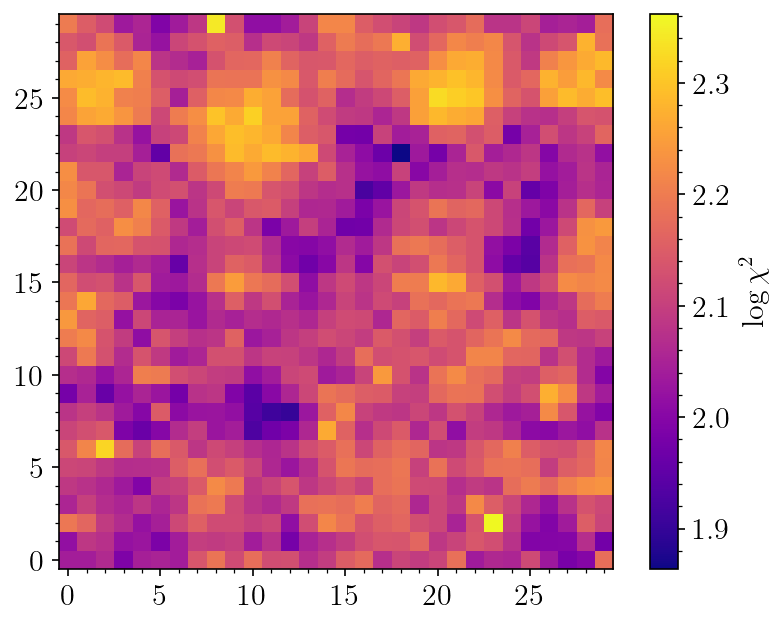

In [88]:
plt.imshow(np.log10(chi2.chi2).T, origin="lower")
plt.colorbar(label=r"$\log \chi^2$")

### Surface plots of different atmospheric parameters

In [37]:
def add_colorbar(fig, ax, im, label=None):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(ax,
                       width="5%",
                       height="100%",
                       loc="lower left",
                       bbox_to_anchor=(1.02, 0., 1, 1),
                       bbox_transform=ax.transAxes,
                       borderpad=0)
    cbar = fig.colorbar(im, cax=axins)
    # cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize="medium")
    if label is not None:
        cbar.set_label(label)

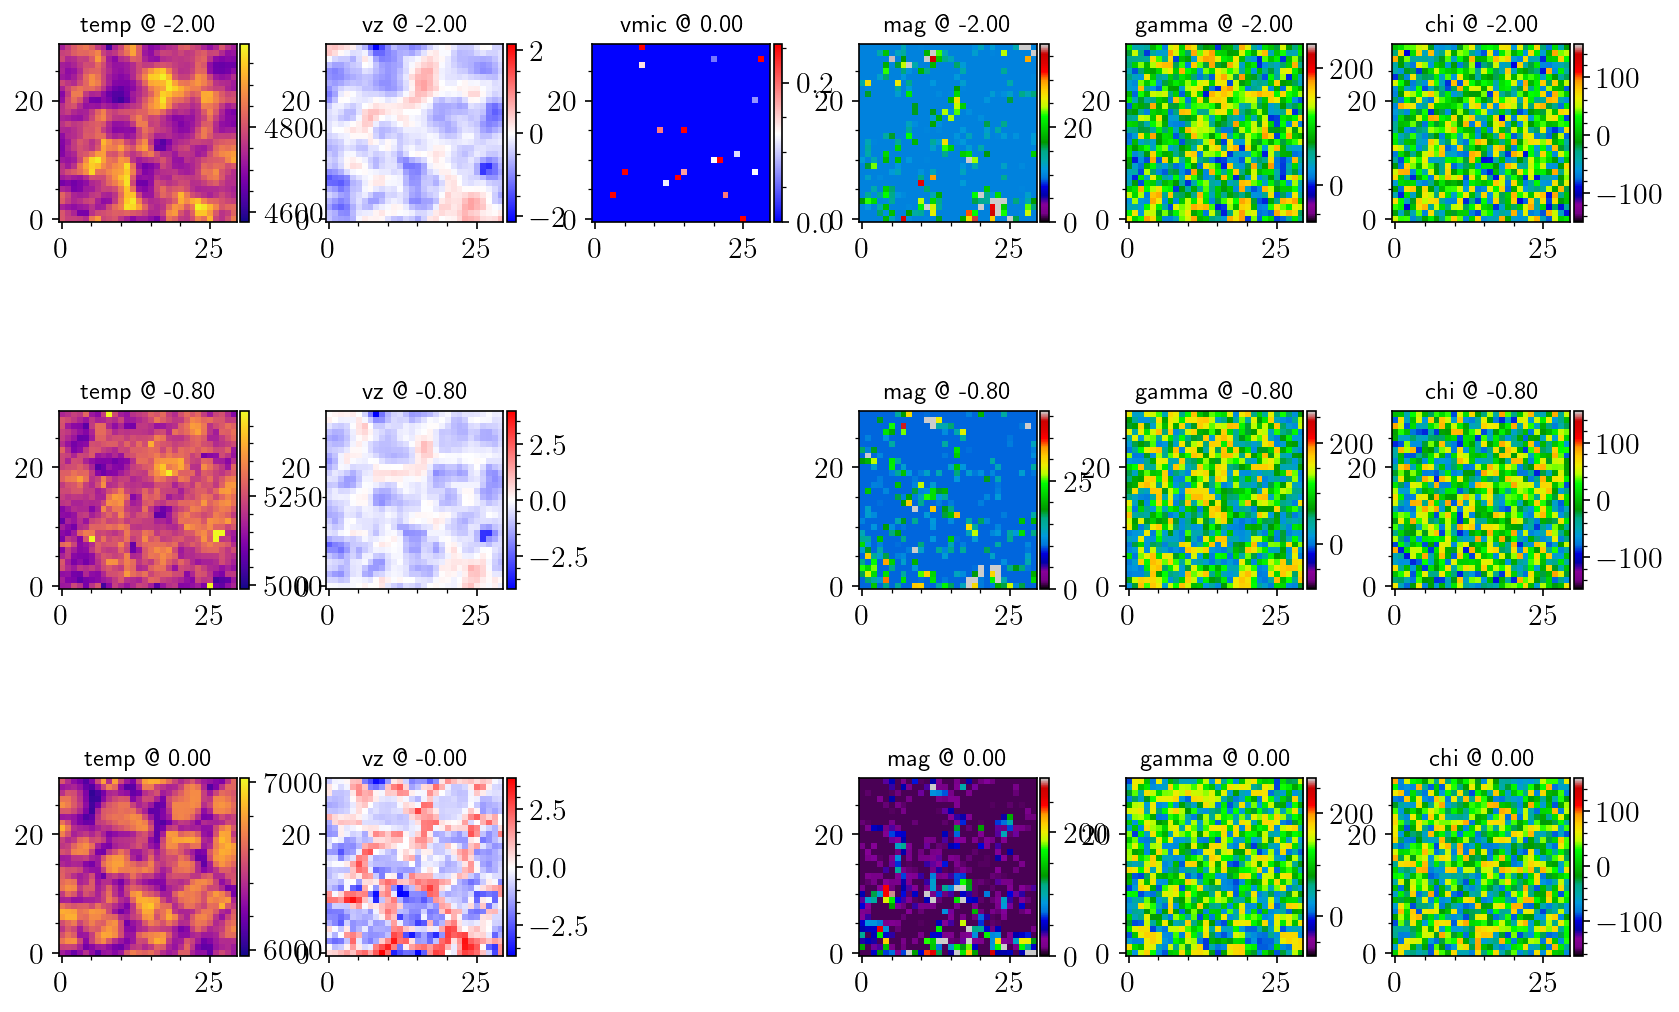

In [89]:
pars = ["temp", "vz", "vmic", "mag", "gamma", "chi"]
cmap = {"temp" : "plasma", "vz" : "bwr", "vmic" : "bwr", 
        "mag" : "nipy_spectral", "gamma" : "nipy_spectral", 
        "chi" : "nipy_spectral", "stray" : "plasma"}

# get the max number of nodes (in one of the parameters)
max_nodes = 0
for par in pars:
    if len(atm.nodes[par])>max_nodes:
        max_nodes = len(atm.nodes[par])

fig = plt.figure(figsize=(13,9))
gs = fig.add_gridspec(nrows=max_nodes, ncols=len(pars), wspace=0.5)

for idp, par in enumerate(pars):
    fact = 1
    if par=="gamma" or par=="chi":
        fact = 180/np.pi
    if par=="vz":
        fact = -1
    for idr in range(len(atm.nodes[par])):
        ax = fig.add_subplot(gs[idr,idp])
        vmax, vmin = None, None
        if par=="vz":
            vlim = np.max(np.abs(atm.values[par][:,:,idr]*fact))
            if vlim>8:
                vlim = 5
            vmax, vmin = vlim, -vlim
#         if par=="temp" and idr==0:
#             vmin, vmax = 4000, 5000
        else:
            mean = np.mean(atm.values[par][...,idr]*fact)
            std = np.std(atm.values[par][...,idr]*fact)
            vmin, vmax = mean - 3*std, mean + 3*std
            if par in ["vmic", "mag"] and vmin<0:
                vmin = 0
            if par=="temp" and vmin<atm.limit_values[par][0]:
                vmin = atm.limit_values[par][0]
        ax.set_title("{:s} @ {:3.2f}".format(par, atm.nodes[par][idr]))
        im = ax.imshow(atm.values[par][:,:,idr].T * fact, origin="lower", cmap=cmap[par], vmax=vmax, vmin=vmin)
        add_colorbar(fig, ax, im)

### Comparison of observed and inverted Stokes spectra for different pixels

In [39]:
ref = None
def plot_spectra(idx, idy):
    globin.visualize.plot_spectra(obs.spec[idx,idy], obs.wavelength, inv=inv.spec[idx,idy])
def plot_atmosphere(idx, idy):
    globin.visualize.plot_atmosphere(atm, ["temp", "vz", "vmic", "mag", "gamma", "chi"], reference=ref, idx=idx, idy=idy)

In [90]:
w1 = widgets.IntSlider(value=0, min=0, max=obs.nx-1, description="idx", continuous_update=False)
w2 = widgets.IntSlider(value=0, min=0, max=obs.ny-1, description="idy", continuous_update=False)

out_s = widgets.interactive_output(plot_spectra, {'idx': w1, 'idy': w2})
out_a = widgets.interactive_output(plot_atmosphere, {'idx': w1, 'idy': w2})
widgets.VBox([widgets.VBox([w1, w2]), widgets.HBox([out_a, out_s])])

In [85]:
np.unravel_index(np.argmax(atm.values["mag"][...,0]), (atm.nx, atm.ny))

(6, 6)

In [83]:
np.argmax(atm.values["mag"])

1622

In [84]:
atm.values["mag"].shape

(30, 30, 3)